## Aim

I am interessted in a numerical framework that can solve systems of the form

$$
\partial_t \mathbf{Q} + \partial_{x_i} \mathbf{F}_i = NC_i \partial_{x_i} \mathbf{Q} + \mathbf{S}
$$

where $\mathbf{F}$ is a flux, $NC$ is a non-conservative matrix, $\mathbf{S}$ is a source term and dimension $i=[1]$ for 1d, $i=[1,2]$ for 2d and $i = [1, 2,3]$ for 3d.

I have the following design thoughts on the solver

* symbolic model description for the PDE (including boundary conditions) using `sympy`. This will in turn allow for the following features
    * symbolic computation of jacobians (flux, source), eigenvalues, ...
    * solver backend can be swapped between C, python, ... due to `sympy`'s  code generation feature 
* pre and postprocessing based on python
    * gmsh compatible 
    * hdf5 as intermediate format
    * vtk conversion
        * pyvista for vtk plotting in jupyter notebooks
* numerics based on path-conservative 1st and 2nd order schemes for unstructured meshes
    * however, it should always be possible to 'hack' a 1d python solver for fast development
* compute intense parts can be solves via
    * python solver (numpy for CPU, jax for GPU)
    * simple C solver on CPU/CPU using KOKKOS
    * parallel C solver using PETSc (both CPU and GPU)
* simple `panel` based GUI. Automatic updating and generation of GUI-elements based on tags defined in the docstrings.


In [22]:
#| code-fold: true
#| code-summary: "Load packages"
#| output: false

import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from copy import deepcopy
import seaborn 
seaborn.set_context('talk')
from IPython.display import Math

main_dir = os.getenv("SMS")
import pytest
from types import SimpleNamespace

from library.model.model import *
from library.pysolver.solver import *
from library.model.models.basisfunctions import * 
from library.model.models.basismatrices import * 
from library.pysolver.solver import jax_fvm_unsteady_semidiscrete as fvm_unsteady
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
from library.pysolver.ode import RK1
import library.misc.io as io
from library.pysolver.reconstruction import GradientMesh
import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing


# Modeling

Defining the model will be purely on a symbolic level based the `sympy` package.

A minimal model is defined by 

* flux or quasilinear matrix
* boundary condition
* initial condition

Optionally, we can also define

* a nonconservative matrix
* the eigenvalues
* a source term 


Let's start by one of the existing models, e.g. the SWEs

## Example 1: 2d SWE

### Mesh

In [23]:
#| code-fold: false
#| code-summary: "Load Gmsh mesh"

# mesh = petscMesh.Mesh.from_gmsh(os.path.join(main_dir, "meshes/quad_2d/mesh_coarse.msh"))
# mesh = petscMesh.Mesh.from_gmsh(os.path.join(main_dir, "meshes/quad_2d/mesh_finer.msh"))
mesh = petscMesh.Mesh.from_gmsh(os.path.join(main_dir, "meshes/triangle_2d/mesh_finer.msh"))
print(f"physical tags in gmsh file: {mesh.boundary_conditions_sorted_names}")



physical tags in gmsh file: ['right' 'left' 'bottom' 'top']


### Model

In [ ]:
#| code-summary: "Model"
#| code-fold: false

bcs = BC.BoundaryConditions(
    [
        BC.Periodic(physical_tag='left', periodic_to_physical_tag='right'),
        BC.Periodic(physical_tag="right", periodic_to_physical_tag='left'),
        BC.Periodic(physical_tag='top', periodic_to_physical_tag='bottom'),
        BC.Periodic(physical_tag="bottom", periodic_to_physical_tag='top'),
    ]
)


def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0]**2 + x[1]**2 < 0.1, 2., 1.)
    return Q

ic = IC.UserFunction(custom_ic)


model = ShallowWater2d(
    boundary_conditions=bcs,
    initial_conditions=ic,
    fields=['h', 'hu', 'hv'],
    settings={"friction": ["chezy"]},
    parameters = {"C": 1.0, "g": 9.81, "ez": 1.0}
)




Since we are using symbolic math currently, we have access to all the nice featues of `sympy`. 
We can for instance, analytically compute
* The Jacobian of the flux/source
* Compute the quasilinear matrix based on the definition of a flux function and nonconservative term
* Compute the analytical eigenvalues of the problem

Let's have a look at the symbolic components of our problem, where

$$
\begin{align*}
& Q_i: \text{state vector} \\
& n_i: \text{normal components} \\
& g, C: \text{parameters}
\end{align*}
$$

:::{.callout-note}
There might apprear $10^{-20}$ expressions in the following functions. These are only present for python-based solver backends, since a constant (e.g. 0 or 1) cannot be converted to vectorizable expression, which needed for a decent runtime for python code.
For C-based solver backends, this workaround is not needed.
:::

### Automatic tex generation

In [25]:
#| code-summary: "Display Model"
#| code-fold: true
if model.dimension == 1:
    display(Math(r'\large{' + 'Flux \, in \, x' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_flux[0])) + '}'))
    display(Math(r'\large{' + 'Nonconservative \, matrix \, in \, x' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_nonconservative_matrix[0])) + '}'))
    display(Math(r'\large{' + 'Quasilinear \, matrix \, in \, x' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_quasilinear_matrix[0])) + '}'))
    display(Math(r'\large{' + 'Eigenvalues' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_eigenvalues)) + '}'))
    display(Math(r'\large{' + 'Source' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_source)) + '}'))
elif model.dimension == 2:
    display(Math(r'\large{' + 'Flux \, in \, x' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_flux[0])) + '}'))
    display(Math(r'\large{' + 'Flux \, in \, y' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_flux[1])) + '}'))
    display(Math(r'\large{' + 'Nonconservative \, matrix \, in \, x' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_nonconservative_matrix[0])) + '}'))
    display(Math(r'\large{' + 'Nonconservative \, matrix \, in \, y' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_nonconservative_matrix[1])) + '}'))
    display(Math(r'\large{' + 'Quasilinear \, matrix \, in \, x' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_quasilinear_matrix[0])) + '}'))
    display(Math(r'\large{' + 'Quasilinear \, matrix \, in \, y' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_quasilinear_matrix[1])) + '}'))
    display(Math(r'\large{' + 'Eigenvalues' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_eigenvalues)) + '}'))
    display(Math(r'\large{' + 'Source' + '}'))
    display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_source)) + '}'))

<>:4: SyntaxWarning: invalid escape sequence '\,'
<>:6: SyntaxWarning: invalid escape sequence '\,'
<>:8: SyntaxWarning: invalid escape sequence '\,'
<>:15: SyntaxWarning: invalid escape sequence '\,'
<>:17: SyntaxWarning: invalid escape sequence '\,'
<>:19: SyntaxWarning: invalid escape sequence '\,'
<>:21: SyntaxWarning: invalid escape sequence '\,'
<>:23: SyntaxWarning: invalid escape sequence '\,'
<>:25: SyntaxWarning: invalid escape sequence '\,'
<>:4: SyntaxWarning: invalid escape sequence '\,'
<>:6: SyntaxWarning: invalid escape sequence '\,'
<>:8: SyntaxWarning: invalid escape sequence '\,'
<>:15: SyntaxWarning: invalid escape sequence '\,'
<>:17: SyntaxWarning: invalid escape sequence '\,'
<>:19: SyntaxWarning: invalid escape sequence '\,'
<>:21: SyntaxWarning: invalid escape sequence '\,'
<>:23: SyntaxWarning: invalid escape sequence '\,'
<>:25: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_393038/935920046.py:4: SyntaxWarning: invalid escape sequence '\,'
  disp

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Simulation

In [26]:
#| code-fold: false
#| code-summary: "Simulation"
#| output: false

settings = Settings(
    reconstruction=recon.constant,
    num_flux=flux.Zero(),
    nc_flux=nonconservative_flux.segmentpath(3),
    compute_dt=timestepping.adaptive(CFL=.45),
    time_end=1.,
    output_snapshots=100,
    output_clean_dir=True,
    output_dir="outputs/demo/swe",
)


fvm_unsteady(
    mesh, model, settings
)


1 0.0014966036452683865 0.0014966036452683865
2 0.0029078941032858875 0.001411290458017501
3 0.004288021999614908 0.0013801278963290202
4 0.005655875965504362 0.0013678539658894535
5 0.007009496080567593 0.0013536201150632316
6 0.008349730228566141 0.0013402341479985481
7 0.00968264294878283 0.001332912720216688
8 0.01101102935009148 0.0013283864013086503
9 0.01233700744905928 0.001325978098967799
10 0.013662022927605842 0.0013250154785465632
11 0.014986952410867341 0.001324929483261499
12 0.016312248051314718 0.0013252956404473746
13 0.017638172908673512 0.001325924857358793
14 0.018964941028441602 0.00132676811976809
15 0.020292760170184006 0.0013278191417424024
16 0.021621145556057233 0.001328385385873227
17 0.022949651027932276 0.0013285054718750432
18 0.02427861673425666 0.0013289657063243817
19 0.02560834473800214 0.0013297280037454803
20 0.02693910043547737 0.0013307556974752283
21 0.028271115865490595 0.0013320154300132257
22 0.029604594195090574 0.0013334783295999779
23 0.0309

Settings(name='Simulation', parameters={}, reconstruction=<function constant at 0x7fc432f585e0>, reconstruction_edge=<function constant_edge at 0x7fc432f58680>, num_flux=<function Zero.<locals>.flux at 0x7fc432abef20>, nc_flux=<function segmentpath.<locals>.nc_flux_quasilinear at 0x7fc432abc400>, compute_dt=<function adaptive.<locals>.compute_dt at 0x7fc432abc220>, time_end=1.0, truncate_last_time_step=True, output_snapshots=100, output_write_all=False, output_dir='outputs/demo/swe', output_clean_dir=True, solver_code_base='python', callbacks=[], debug=False, profiling=False, compute_gradient=False, precice_config_path='/home/ingo/Desktop/precice-tutorial/partitioned-backwards-facing-step/precice-config.xml')

### Postprocessing

In [27]:
#| code-fold: true
#| code-summary: "Postprocessing"
io.generate_vtk(os.path.join(os.path.join(main_dir, settings.output_dir), f'{settings.name}.h5'))
out_0 = pv.read(os.path.join(os.path.join(main_dir, settings.output_dir), 'out.0.vtk'))
out_10 = pv.read(os.path.join(os.path.join(main_dir, settings.output_dir), 'out.10.vtk'))
out_98 = pv.read(os.path.join(os.path.join(main_dir, settings.output_dir), 'out.98.vtk'))
field_names = out_0.cell_data.keys()
print(f'Field names: {field_names}')

Field names: ['0', '1', '2']


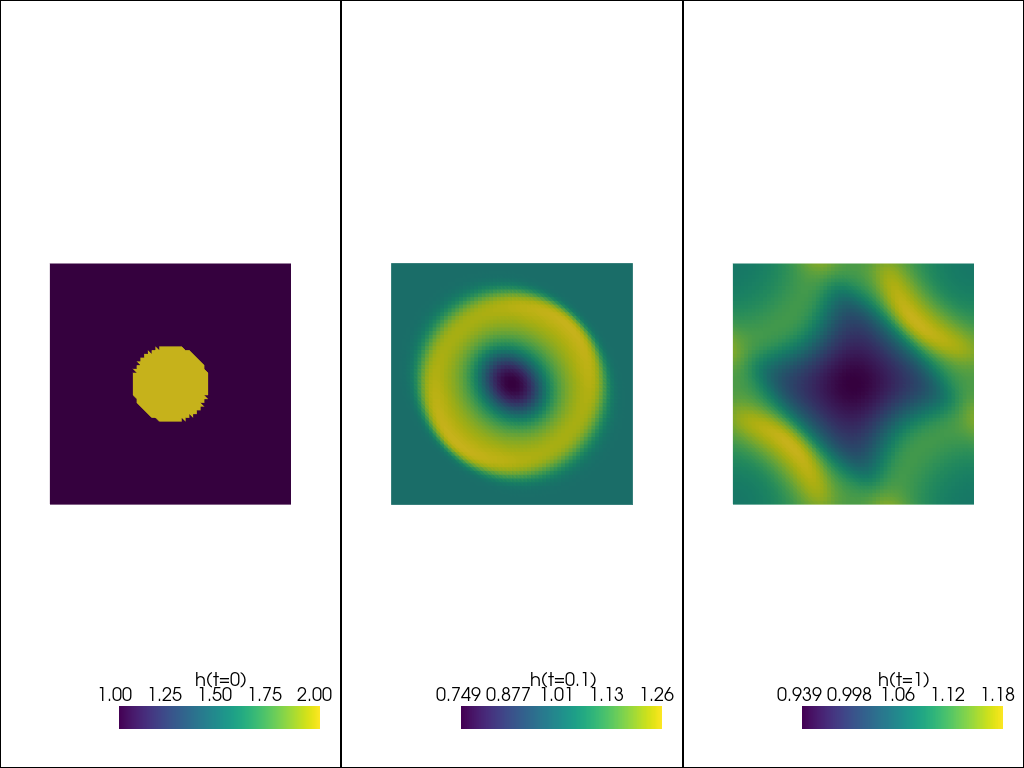

In [28]:
#| code-fold: true
#| code-summary: "Plot VTK"
p = pv.Plotter(shape=(1,3), notebook=True)

p.subplot(0, 0)
p.add_mesh(out_0, scalars='0', show_edges=False, scalar_bar_args={'title': 'h(t=0)'})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.subplot(0, 1)
p.add_mesh(out_10, scalars='0', show_edges=False, scalar_bar_args={'title': 'h(t=0.1)'})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.subplot(0, 2)
p.add_mesh(out_98, scalars='0', show_edges=False, scalar_bar_args={'title': 'h(t=1)'})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.show(jupyter_backend='static')

## Example 2: 2d Shallow Moments

### Mesh

In [ ]:
#| code-fold: true
#| code-summary: "Read GMSH mesh"
mesh = petscMesh.Mesh.from_gmsh(os.path.join(main_dir, "meshes/quad_2d/mesh_finest.msh"))
print(f"physical tags in gmsh file: {mesh.boundary_conditions_sorted_names}")



physical tags in gmsh file: ['right' 'left' 'bottom' 'top']


### Model

In [ ]:
#| code-fold: false
#| code-summary: "Model"
level = 1
bcs = BC.BoundaryConditions(
    [
        BC.Periodic(physical_tag='left', periodic_to_physical_tag='right'),
        BC.Periodic(physical_tag="right", periodic_to_physical_tag='left'),
        BC.Periodic(physical_tag='top', periodic_to_physical_tag='bottom'),
        BC.Periodic(physical_tag="bottom", periodic_to_physical_tag='top'),
    ]
)

def custom_ic_smm(x):
    Q = np.zeros(3 + 2*level, dtype=float)
    Q[0] = np.where(x[0]**2 + x[1]**2 < 0.1, 2., 1.)
    return Q

ic_smm = IC.UserFunction(custom_ic_smm)

model_smm = ShallowMoments2d(
    fields = 3 + 2*level,
    boundary_conditions=bcs,
    initial_conditions=ic_smm,
    settings={"friction": ["chezy"]},
    parameters = {"C": 1.0, "g": 9.81, "ez": 1.0},
    basis = Basismatrices(basis=Legendre_shifted(order=level+1))
)

### Automatic tex generation

In [ ]:
#| code-summary: "Display Model"
#| code-fold: true
display(Math(r'\large{' + 'Flux \, in \, x' + '}'))
display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_flux[0])) + '}'))
display(Math(r'\large{' + 'Nonconservative \, matrix \, in \, x' + '}'))
display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_nonconservative_matrix[0])) + '}'))
display(Math(r'\large{' + 'Eigenvalues' + '}'))
display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_eigenvalues)) + '}'))
display(Math(r'\large{' + 'Source' + '}'))
display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_source)) + '}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Simulation

In [ ]:
#| code-fold: false
#| code-summary: "Simulation"
#| output: false

settings = Settings(
    reconstruction=recon.constant,
    num_flux=flux.LLF(),
    nc_flux=nonconservative_flux.segmentpath(1),
    compute_dt=timestepping.adaptive(CFL=.45),
    time_end=1.,
    output_snapshots=100,
    output_clean_dir=True,
    output_dir="outputs/output_introduction/smm",
)
fvm_unsteady(
    mesh, model_smm, settings, ode_solver_source=RK1
)

1 0.001587387800335407 0.001587387800335407---------------------- 
2 0.0031179802094531113 0.001530592409117704
3 0.004602535240342149 0.001484555030889037
4 0.006061138705357198 0.0014586034650150494
5 0.007504708227390747 0.0014435695220335492
6 0.008940294189528596 0.001435585962137849
7 0.01036920502188564 0.0014289108323570449
8 0.01179055816964347 0.0014213531477578311
9 0.013208903910487416 0.001418345740843944
10 0.01462573001249016 0.0014168261020027443
11 0.01604225362575077 0.0014165236132606116
12 0.01745898364266795 0.0014167300169171803
13 0.018876200064708505 0.001417216422040556
14 0.02029422593454719 0.0014180258698386818
15 0.02171306014716859 0.001418834212621401
16 0.023132621658778597 0.0014195615116100071
17 0.024552581435027445 0.0014199597762488499
18 0.0259730448529086 0.0014204634178811531
19 0.027394171746304034 0.001421126893395435
20 0.028816101141235295 0.0014219293949312617
21 0.03023895623778291 0.001422855096547616
22 0.03166230437995563 0.0014233481421

Settings(name='Simulation', parameters={}, reconstruction=<function constant at 0x7fb325f24ee0>, reconstruction_edge=<function constant_edge at 0x7fb325f24f70>, num_flux=<function LLF.<locals>.flux at 0x7fb2e40d53a0>, nc_flux=<function segmentpath.<locals>.nc_flux_vectorized at 0x7fb2e40d5280>, compute_dt=<function adaptive.<locals>.compute_dt at 0x7fb2e40d5310>, time_end=1.0, truncate_last_time_step=True, output_snapshots=100, output_write_all=False, output_dir='outputs/output_introduction/smm', output_clean_dir=True, solver_code_base='python', callbacks=[], debug=False, profiling=False)

### Postprocessing

In [ ]:
#| code-fold: true
#| code-summary: "Postprocessing"
io.generate_vtk(os.path.join(os.path.join(main_dir, settings.output_dir), f'{settings.name}.h5'))
out_0 = pv.read(os.path.join(os.path.join(main_dir, settings.output_dir), 'out.0.vtk'))
out_49 = pv.read(os.path.join(os.path.join(main_dir, settings.output_dir), 'out.10.vtk'))
out_98 = pv.read(os.path.join(os.path.join(main_dir, settings.output_dir), 'out.98.vtk'))
field_names = out_0.cell_data.keys()
print(field_names)

['0', '1', '2', '3', '4']


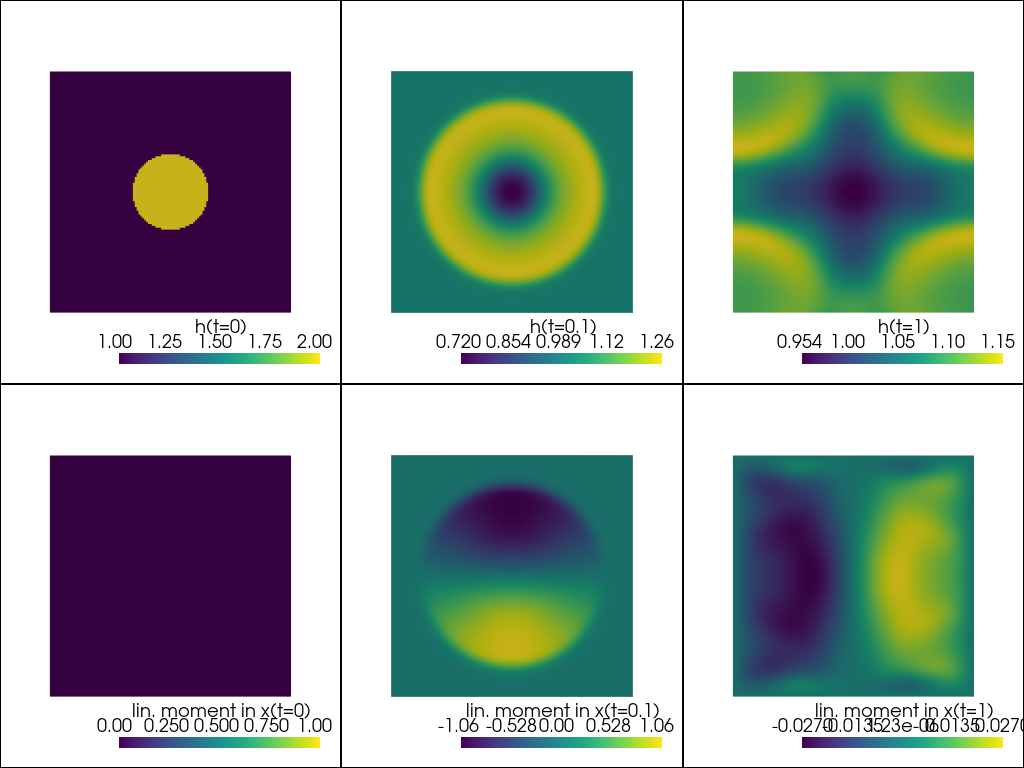

In [ ]:
#| code-fold: true
#| code-summary: "Plot VTK"
p = pv.Plotter(shape=(2,3), notebook=True)

p.subplot(0, 0)
p.add_mesh(out_0, scalars='0', show_edges=False, scalar_bar_args={'title': 'h(t=0)'})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.subplot(0, 1)
p.add_mesh(out_10, scalars='0', show_edges=False, scalar_bar_args={'title': 'h(t=0.1)'})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.subplot(0, 2)
p.add_mesh(out_98, scalars='0', show_edges=False, scalar_bar_args={'title': 'h(t=1)'})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.subplot(1, 0)
p.add_mesh(out_0.copy(), scalars='2', show_edges=False, scalar_bar_args={'title': 'lin. moment in x(t=0)'})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.subplot(1, 1)
p.add_mesh(out_10.copy(), scalars='2', show_edges=False, scalar_bar_args={'title': 'lin. moment in x(t=0.1)'})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.subplot(1, 2)
p.add_mesh(out_98.copy(), scalars='2', show_edges=False, scalar_bar_args={'title': 'lin. moment in x(t=1)'})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.show(jupyter_backend='static')

## Example 3: Create your own model

### Model definition

In [ ]:
n_fields = 3
#| code-fold: false
#| code-summary: "Construct your own model"
class Euler1D(Model):

    def __init__(
        self,
        boundary_conditions,
        initial_conditions,
        parameters = {},
        settings={},
    ):
        super().__init__(
            dimension=1,
            fields=3,
            aux_fields=0,
            parameters=parameters,
            boundary_conditions=boundary_conditions,
            initial_conditions=initial_conditions,
            # aux_initial_conditions=aux_initial_conditions,
            settings=settings,
        )

    def get_system_variables(self):
        Q = self.variables
        rho = Q[0]
        rho_u = Q[1]
        u = rho_u / rho
        E = Q[2]
        e = E/rho - 1/2 * u**2
        gamma = self.parameters.gamma
        p =  (gamma-1)*rho*e
        return rho, u, e, p, E, gamma


    def flux(self):
        flux_x = Matrix([0 for i in range(3)])
        rho, u, e, p, E, gamma = self.get_system_variables()
        flux_x[0] = rho * u
        flux_x[1] = rho * u * u + p
        flux_x[2] = E * u + p * u
        return [flux_x]


    def source(self):
        assert "C1" in vars(self.parameters)
        S = Matrix([0 for i in range(self.n_fields)])
        rho, u, e, p, E, gamma = self.get_system_variables()
        S[1] = - self.parameters.C1 * p
        S[2] = - self.parameters.C1 * p * u
        return S

### Mesh and model construction

In [ ]:
#| code-fold: true
#| code-summary: "Initialize model and mesh"
mesh = petscMesh.Mesh.create_1d((-5, 5), 100)

bcs = BC.BoundaryConditions(
    [
        BC.Extrapolation(physical_tag='left'),
        BC.Extrapolation(physical_tag="right"),
    ]
)

model_euler = Euler1D(
    boundary_conditions = bcs,
    initial_conditions = IC.RP(
        high=lambda n_field: np.array([1., -0.1 , 1.]),
        low=lambda n_field: np.array([1.,  +0.1, 1.]),
    ),
    parameters = {'gamma': 1.6, 'C1': 0.},
)

### Automatic tex generation

In [ ]:
#| code-fold: true
#| code-summary: "Display model"
display(Math(r'\large{' + 'Flux \, in \, x' + '}'))
display(Math(r'\large{' + sympy.latex(sympy.simplify(model_euler.sympy_flux[0])) + '}'))
display(Math(r'\large{' + 'Nonconservative \, matrix \, in \, x' + '}'))
display(Math(r'\large{' + sympy.latex(sympy.simplify(model_euler.sympy_nonconservative_matrix[0])) + '}'))
display(Math(r'\large{' + 'Eigenvalues' + '}'))
display(Math(r'\large{' + sympy.latex(sympy.simplify(model_euler.sympy_eigenvalues)) + '}'))
display(Math(r'\large{' + 'Source' + '}'))
display(Math(r'\large{' + sympy.latex(sympy.simplify(model_euler.sympy_source)) + '}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Simulation

In [ ]:
#| code-fold: false
#| code-summary: "Run simulation"
#| output: false

settings = Settings(
    reconstruction=recon.constant,
    num_flux=flux.LLF(),
    nc_flux=nonconservative_flux.segmentpath(1),
    compute_dt=timestepping.adaptive(CFL=.9),
    time_end=1.,
    output_snapshots=100,
    output_clean_dir=True,
    output_dir="outputs/output_introduction/euler",
)

fvm_unsteady(
    mesh, model_euler, settings, ode_solver_source=RK1
)

1 0.08353882818945031 0.08353882818945031------------------------ 
2 0.16707765637890062 0.08353882818945031
3 0.25061648456835095 0.08353882818945031
4 0.33415531275780125 0.08353882818945031
5 0.41769414094725155 0.08353882818945031
6 0.5012329691367019 0.08353882818945031
7 0.5847717973261523 0.08353882818945031
8 0.6683106255156026 0.08353882818945031
9 0.751849453705053 0.08353882818945031
10 0.8353882818945033 0.08353882818945031
11 0.9189271100839537 0.08353882818945031
12 1.0000000001 0.08107289001604633



Settings(name='Simulation', parameters={}, reconstruction=<function constant at 0x7fb325f24ee0>, reconstruction_edge=<function constant_edge at 0x7fb325f24f70>, num_flux=<function LLF.<locals>.flux at 0x7fb2c26f8940>, nc_flux=<function segmentpath.<locals>.nc_flux_vectorized at 0x7fb2c26f8790>, compute_dt=<function adaptive.<locals>.compute_dt at 0x7fb2c26f8f70>, time_end=1.0, truncate_last_time_step=True, output_snapshots=100, output_write_all=False, output_dir='outputs/output_introduction/euler', output_clean_dir=True, solver_code_base='python', callbacks=[], debug=False, profiling=False)

In [ ]:
#| code-fold: true
#| code-summary: "Postprocessing"
filepath = os.path.join(settings.output_dir, 'Simulation.h5')
X, Q, Qaux, T = io.load_timeline_of_fields_from_hdf5(filepath)
# remove the boundary points
Q = Q[:, :, :-2]
X = X[:-2]

### Postprocessing

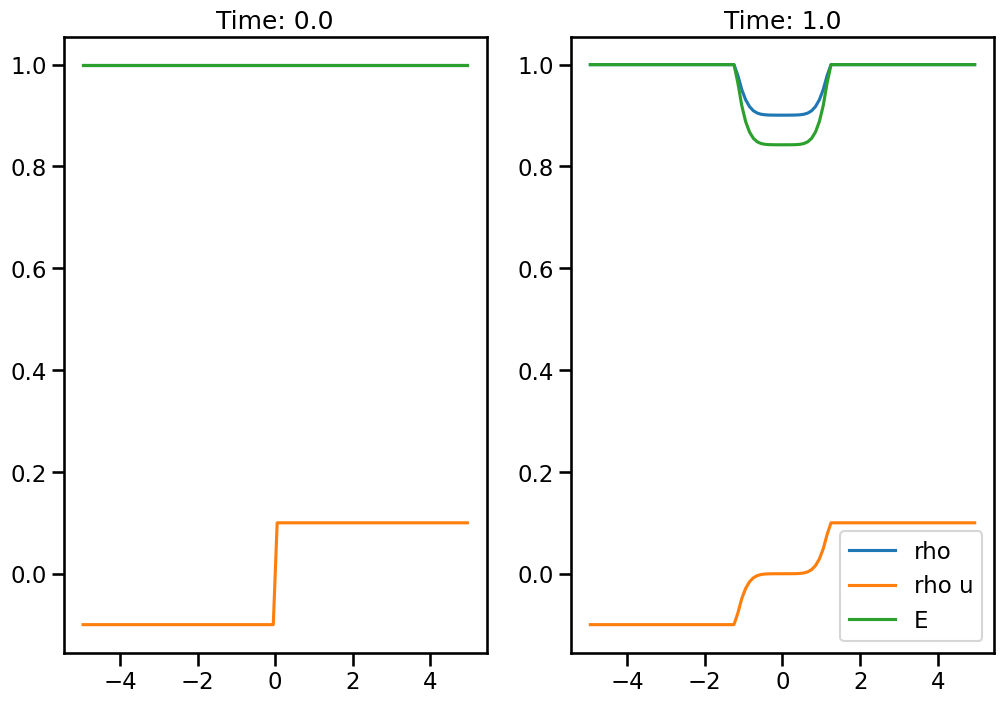

In [ ]:
#| code-fold: false
#| code-summary: "Plot with Matplotlib"
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
i_time = 0
ax[0].plot(X, Q[i_time, 0, :], label='rho')
ax[0].plot(X, Q[i_time, 1, :], label='rho u')
ax[0].plot(X, Q[i_time, 2, :], label='E')
ax[0].set_title(f'Time: {T[i_time]}')

i_time = -1
ax[1].plot(X, Q[i_time, 0, :], label='rho')
ax[1].plot(X, Q[i_time, 1, :], label='rho u')
ax[1].plot(X, Q[i_time, 2, :], label='E')
ax[1].set_title(f'Time: {np.round(T[i_time], 1)}')
plt.legend()